In [393]:
# script libraries
import data
# data handling
import pandas as pd
import numpy as np
# machine learning
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking, BatchNormalization
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, fbeta_score, roc_curve, auc, accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Model
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from hist import Hist
import hist
from matplotlib.patches import Rectangle
from tqdm import tqdm

## Setup code

In [394]:
def crop_waveforms(waveforms_df, crop_value, crop_set, location):

    """
    Removes crop_value time steps from ether front or back of waveform depending on location value
    Inputs: 
        waveforms_df: Waveform dataframe with assigned truth va/lues 
        crop_value: number of time steps to remove
        location: 'front' or 'back' - determines which end of the waveform to crop from
    """

    padding_name = '{}_{}'.format(crop_value,location)
    def crop(waveform, crop_value, location):
        if location == 'front':
                return waveform[crop_value:] 
        if location == 'back':
            return waveform[:-crop_value] 

    waveforms_df[padding_name] = waveforms_df[crop_set].apply(lambda x: crop(x,crop_value,location))        
    return waveforms_df

In [426]:
# load in padded dataset
chonky_padded_waveforms = pd.read_parquet('padded_waveforms.parquet')
# us to timesteps
us2timesteps = 100
# finalising the data arrays
cropped_back = crop_waveforms(chonky_padded_waveforms, 900, 'chonkers', location='back')
# cropped_back.info()
cropped_back_padded_front = crop_waveforms(cropped_back, 600, '900_back', location='front')
# cropped_back_padded_front.info()
padded_array = cropped_back_padded_front['600_front'].to_numpy()
# print(padded_array.shape)
print(chonky_padded_waveforms['length'].max())
print(chonky_padded_waveforms['length'].min())
print(np.mean(chonky_padded_waveforms['length'].to_numpy()))
print(np.std(chonky_padded_waveforms['length'].to_numpy()))

1828
165
771.5612952968388
193.0074716822617


In [396]:
x_data = np.stack(padded_array, axis=0)
# divide by max phd
max_phd = x_data.max()
x_data = x_data / max_phd
# set all values less than zero (probs due to noise) to zero. I think this is the correct way to do this?
x_data[x_data < 0] = 0
# waveform intensity range should now be between zero and 1.
print(x_data.min())
print(x_data.max())
print(x_data.shape)
y_data = chonky_padded_waveforms['label'].to_numpy().reshape((-1,1))
print(y_data.shape)
input_length = x_data.shape[-1]
print(input_length)

0.0
1.0
(7782, 1528)
(7782, 1)
1528


In [397]:
# get training and testing sets
runID = chonky_padded_waveforms['runID']
eventID = chonky_padded_waveforms['eventID']
W_array = chonky_padded_waveforms['weights_no_gas'].to_numpy()
E = chonky_padded_waveforms['ext_elec'].to_numpy()


X_train, X_test, \
y_train, y_test, \
W_train, W_test, \
E_train, E_test, \
runID_train, runID_test, \
eventID_train, eventID_test = \
train_test_split(x_data, y_data, W_array, E, runID, eventID, random_state=0, test_size=0.15)
print(X_train.shape)
print(y_train.shape)
print(X_train)
print(y_train)
X_train_reshaped = np.expand_dims(X_train, axis=-1)
print(X_train_reshaped.shape)

print(W_train.shape)

print(E_train.shape)
print(E_test.shape)

(6614, 1528)
(6614, 1)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[2]
 [2]
 [1]
 ...
 [1]
 [1]
 [1]]
(6614, 1528, 1)
(6614,)
(6614,)
(1168,)


In [398]:
two_layer_CNN_model = keras.Sequential([
        keras.layers.Conv1D(filters=6,kernel_size=900,activation='relu', input_shape=(input_length, 1)),
        # keras.layers.BatchNormalization(),
        keras.layers.Conv1D(filters=38,kernel_size=39,activation='relu'),
        # keras.layers.MaxPooling1D(5),
        # keras.layers.BatchNormalization(),
        # keras.layers.Masking(mask_value=0, input_shape=(input_length, 1)),
        # keras.layers.Conv1D(filters=6,kernel_size=900,activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(3, activation='softmax')
    ])

two_layer_CNN_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 629, 6)            5406      
                                                                 
 conv1d_37 (Conv1D)          (None, 591, 38)           8930      
                                                                 
 flatten_18 (Flatten)        (None, 22458)             0         
                                                                 
 dense_18 (Dense)            (None, 3)                 67377     
                                                                 
Total params: 81713 (319.19 KB)
Trainable params: 81713 (319.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [399]:
two_layer_CNN_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00003),
                            loss='sparse_categorical_crossentropy',#'binary_crossentropy',
                            metrics=['accuracy'],
                            weighted_metrics=['accuracy'])

In [400]:
# callback = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                          patience=15)
hist_two_layer_CNN_model = two_layer_CNN_model.fit(X_train,y_train,epochs=150, validation_split=0.15, shuffle=True, sample_weight=W_train)#, callbacks=[callback])

Epoch 1/150
176/176 [==============================] - 4s 22ms/step - loss: 0.0376 - accuracy: 0.2959 - weighted_accuracy: 0.3931 - val_loss: 0.0326 - val_accuracy: 0.5509 - val_weighted_accuracy: 0.5757
Epoch 2/150
176/176 [==============================] - 4s 21ms/step - loss: 0.0287 - accuracy: 0.7358 - weighted_accuracy: 0.7030 - val_loss: 0.0212 - val_accuracy: 0.7482 - val_weighted_accuracy: 0.8358
Epoch 3/150
176/176 [==============================] - 4s 20ms/step - loss: 0.0181 - accuracy: 0.7760 - weighted_accuracy: 0.8532 - val_loss: 0.0160 - val_accuracy: 0.8016 - val_weighted_accuracy: 0.8646
Epoch 4/150
176/176 [==============================] - 3s 20ms/step - loss: 0.0155 - accuracy: 0.8120 - weighted_accuracy: 0.8722 - val_loss: 0.0145 - val_accuracy: 0.8197 - val_weighted_accuracy: 0.8743
Epoch 5/150
176/176 [==============================] - 3s 20ms/step - loss: 0.0144 - accuracy: 0.8230 - weighted_accuracy: 0.8784 - val_loss: 0.0137 - val_accuracy: 0.8328 - val_weight

In [401]:
test_loss, test_acc, test_weight_acc = two_layer_CNN_model.evaluate(X_test,y_test, sample_weight=W_test)

37/37 [==============================] - 1s 14ms/step - loss: 0.0115 - accuracy: 0.8827 - weighted_accuracy: 0.8933


## Figuring out how the best model learns

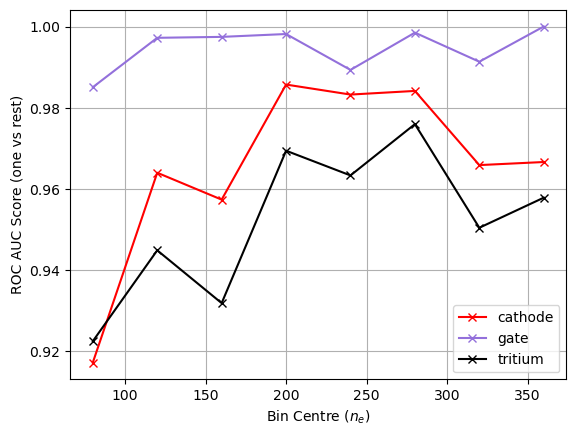

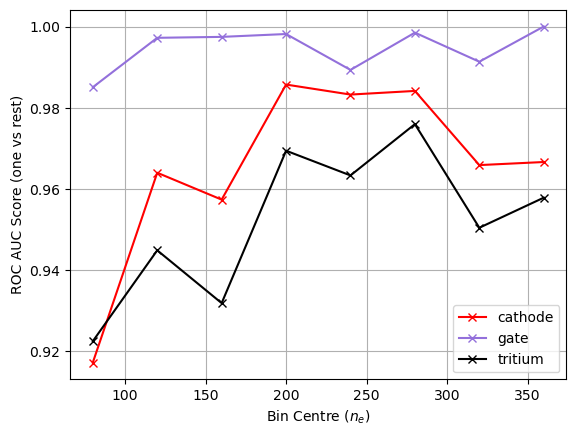

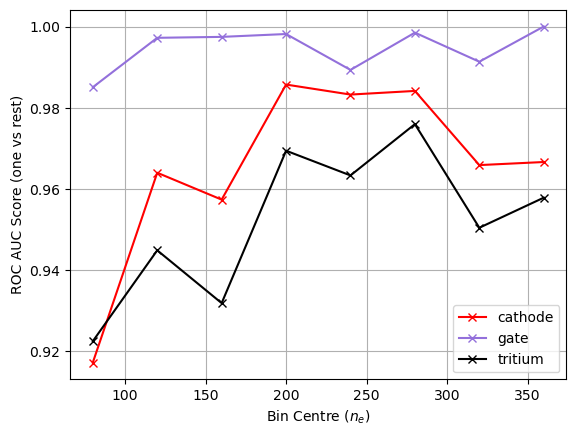

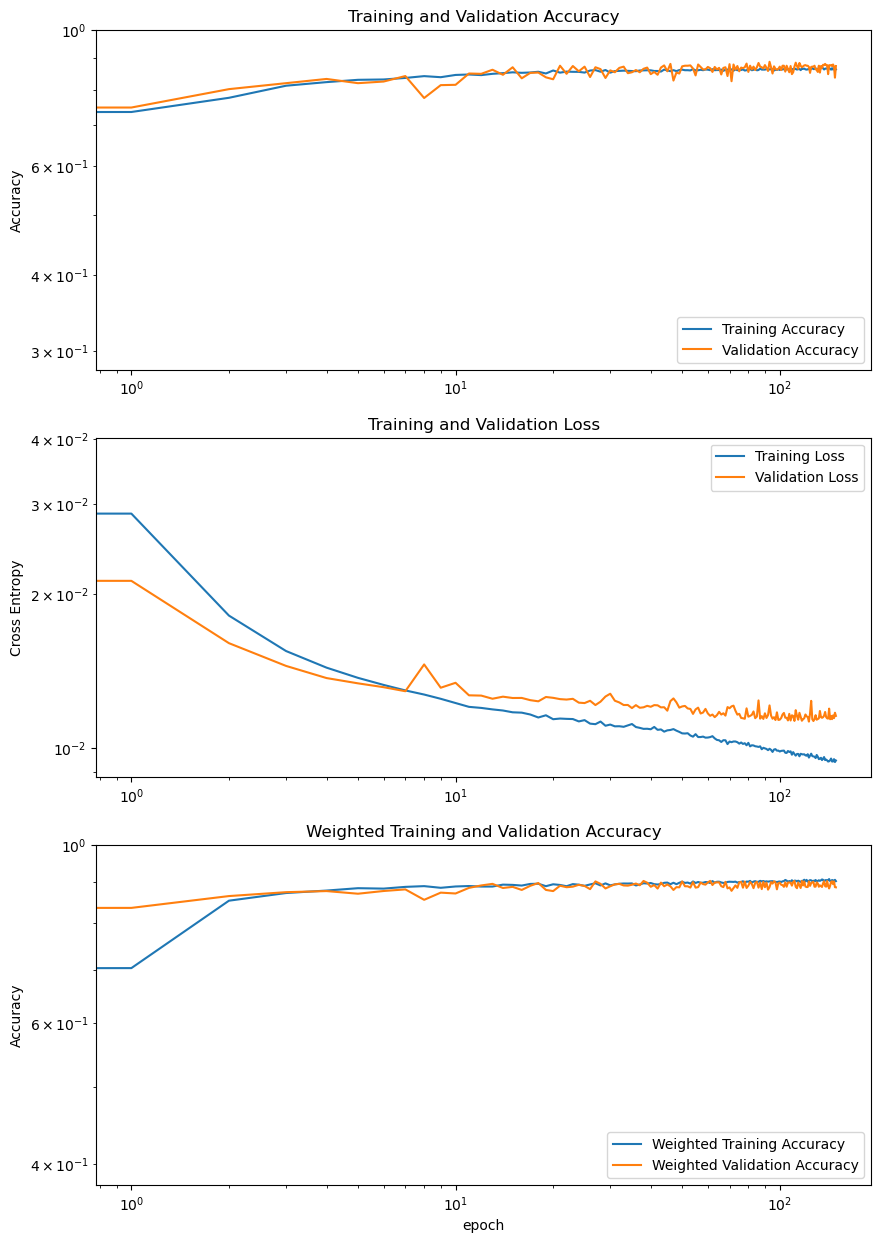

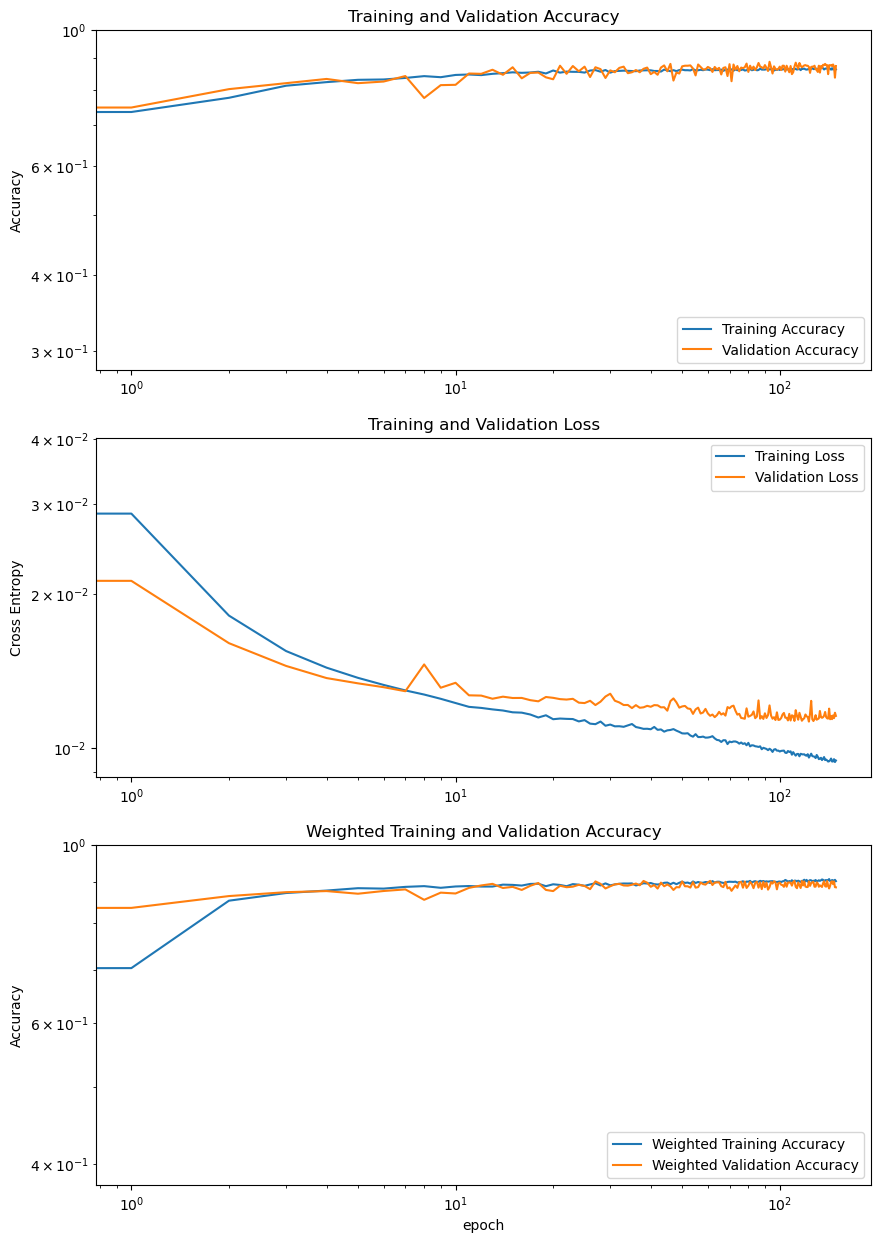

In [446]:
# plotting training history

acc = hist_two_layer_CNN_model.history['accuracy']
val_acc = hist_two_layer_CNN_model.history['val_accuracy']
w_acc = hist_two_layer_CNN_model.history['weighted_accuracy']
w_val_acc = hist_two_layer_CNN_model.history['val_weighted_accuracy']

loss = hist_two_layer_CNN_model.history['loss']
val_loss = hist_two_layer_CNN_model.history['val_loss']
# w_loss = hist_paddedCNN.history['weighted_loss']
# w_val_loss = hist_paddedCNN.history['val_weighted_loss']

plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 1)
plt.loglog(acc, label='Training Accuracy')
plt.loglog(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.loglog(loss, label='Training Loss')
plt.loglog(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

# plotting weighted mertrics

plt.subplot(3, 1, 3)
plt.loglog(w_acc, label='Weighted Training Accuracy')
plt.loglog(w_val_acc, label='Weighted Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Weighted Training and Validation Accuracy')
plt.xlabel('epoch')
plt.savefig('final_learncurv_no_wacc.pdf', format='pdf')
plt.show()

In [403]:
# generating confusion matrix info

y_predicted = two_layer_CNN_model.predict(X_test) # these are the "probabilities" associated with the classification
y_predicted_label = [np.argmax(i) for i in y_predicted] # these are the predictions

37/37 [==============================] - 0s 5ms/step


In [447]:
# plotting confusion matrix

# plt.figure(figsize = (10,7))
# sns.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_label),
#            annot=True, 
#            fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')

plt.figure(figsize = (10,7))
cf_matrix = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_label).numpy()

# group_names = ['True Cathode','False Gate', 'False Signal', 
#                'False Cathode','True Gate', 'False Signal',
#                'False']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
#labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
          #zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('final_confmat_labelled.pdf', format='pdf')


In [405]:
print(y_test.shape)
print(y_predicted.shape)

print(classification_report(y_test, y_predicted_label, labels=[0, 1, 2], target_names=['cathode', 'gate', 'tritium'], sample_weight=W_test))

print('Tritium F2 Score' + str(fbeta_score(y_test, y_predicted_label, beta=2, labels=[2], average=None)))
print('Tritium F3 Score' + str(fbeta_score(y_test, y_predicted_label, beta=3, labels=[2], average=None)))

(1168, 1)
(1168, 3)
              precision    recall  f1-score   support

     cathode       0.87      0.85      0.86 14.913075571472367
        gate       0.97      0.97      0.97 15.891833472188548
     tritium       0.83      0.85      0.84 14.466853491551715

    accuracy                           0.89 45.27176253521263
   macro avg       0.89      0.89      0.89 45.27176253521263
weighted avg       0.89      0.89      0.89 45.27176253521263

Tritium F2 Score[0.87221095]
Tritium F3 Score[0.86357768]


# roc curves testing

In [406]:
# For ROC AUC, assuming `y_pred_proba` is the prediction probabilities and `y_true` is label encoded
roc_auc = roc_auc_score(y_test, y_predicted, sample_weight=W_test, multi_class="ovr", average=None)#, labels=['cathode', 'gate', 'tritium'])
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: [0.96918878 0.99352206 0.95221418]


In [407]:
bin_labels = ['Total', r'60 < $n_e$ < 100', r'100 < $n_e$ < 140', r'140 < $n_e$ < 180', r'180 < $n_e$ < 220',
              r'220 < $n_e$ < 260', r'260 < $n_e$ < 300', r'300 < $n_e$ < 340', r'340 < $n_e$ < 380']
bin_colors = ["black", "purple", "darkblue", "cyan", "green", "gold", "orange", "red", "hotpink"  ]
bin_centres = [80, 120, 160, 200, 240, 280, 320, 360]

In [444]:
# splitting into gate and cathode
# ROC_params_gate = []
ROC_AUCs = []
# ROC_params_cath = []
# ROC_AUC_cath = []
# ratios_cath = []
# ratios_gate = []
# maxes_cath = []
# maxes_gate = []
# bin_counts = []
start = 60
print('Results in order [cathode, gate, tritium]')
for i in range(8):
    print(bin_labels[i+1])
    # trit_cut_ = y_test != 'tritium'
    bin_cut = (start < E_test) & (E_test < start + 40)
    start += 40

    gate_cut_ =  y_test != 0#'cathode' 
    # FPR, TPR, TH = roc_curve(Y_test[bin_cut&gate_cut_], sc_Y_score[bin_cut&gate_cut_],sample_weight = W_test[bin_cut&gate_cut_], pos_label = 1)
    # ROC_params_gate.append([FPR, TPR, TH])
    roc_area = roc_auc_score(y_test[np.where(bin_cut)], y_predicted[np.where(bin_cut)],sample_weight = W_test[np.where(bin_cut)], multi_class="ovr", average=None)
    roc_area = roc_auc_score(y_test[np.where(bin_cut)], y_predicted[np.where(bin_cut)],sample_weight = W_test[np.where(bin_cut)], multi_class="ovr", average=None)
    
    # roc_area = roc_auc_score(y_test[np.where(bin_cut)], y_predicted[np.where(bin_cut)], multi_class="ovo", average='weighted')
    # roc_area = roc_auc_score(y_test[np.where(bin_cut)], y_predicted[np.where(bin_cut)], multi_class="ovo", average='weighted')

    ROC_AUCs.append(roc_area)
    print('ROC AUC - ' + str(roc_area))
    # ratio_gate = eff_calc(TPR, FPR)
    # ratios_gate.append(ratio_gate)
    # ind = np.where(ratio_gate == np.max(ratio_gate))
    # maxes_gate.append([TPR[ind], FPR[ind]])

    # cath_cut_ =  y_test != 1#'gate' 
    # FPR, TPR, TH = roc_curve(Y_test[bin_cut&cath_cut_], sc_Y_score[bin_cut&cath_cut_],sample_weight = W_test[bin_cut&cath_cut_], pos_label = 1)
    # ROC_params_cath.append([FPR, TPR, TH])
    # roc_area = roc_auc_score(y_test[bin_cut&cath_cut_], sc_Y_score[bin_cut&cath_cut_],sample_weight = W_test[bin_cut&cath_cut_])
    # ROC_AUC_cath.append(roc_area)
    # print('ROC AUC Cathode - ' + str(roc_area))
    # print()
    # ratio_cath = eff_calc(TPR, FPR)
    # ratios_cath.append(ratio_cath)
    # ind = np.where(ratio_cath == np.max(ratio_cath))
    # maxes_cath.append([TPR[ind], FPR[ind]])
    # bin_counts.append([len(E_test[bin_cut]), len(E_test[bin_cut&cath_cut_&gate_cut_]), len(E_test[bin_cut&trit_cut_&gate_cut_]), len(E_test[bin_cut&trit_cut_&cath_cut_])])
# print(bin_counts)

ROC_AUC_arr = np.array(ROC_AUCs)

# plt.rcParams.update(plt.rcParamsDefault)

plt.figure()
plt.plot(bin_centres, ROC_AUC_arr[:,0], marker='x', color='red', label='cathode')
plt.plot(bin_centres, ROC_AUC_arr[:,1], marker='x', color='mediumpurple', label='gate')
plt.plot(bin_centres, ROC_AUC_arr[:,2], marker='x', color='black', label='tritium')
plt.xlabel(r'Bin Centre ($n_e$)')
plt.ylabel('ROC AUC Score (one vs rest)')
plt.grid()
plt.legend()
plt.savefig('final_rocauc.pdf', format='pdf')


Results in order [cathode, gate, tritium]
60 < $n_e$ < 100
ROC AUC - [0.91725723 0.98505457 0.92250732]
100 < $n_e$ < 140
ROC AUC - [0.96399116 0.99721985 0.94488619]
140 < $n_e$ < 180
ROC AUC - [0.95736998 0.99744942 0.9318853 ]
180 < $n_e$ < 220
ROC AUC - [0.98570696 0.99815427 0.96941677]
220 < $n_e$ < 260
ROC AUC - [0.98324388 0.98931105 0.96333121]
260 < $n_e$ < 300
ROC AUC - [0.98413964 0.99849525 0.97596238]
300 < $n_e$ < 340
ROC AUC - [0.96587591 0.99133148 0.95044404]
340 < $n_e$ < 380
ROC AUC - [0.96663283 1.         0.95785423]


# disc analysis

In [409]:
y_predicted.shape

(1168, 3)

In [410]:
bin1 = (60 < E_test) & (E_test < 100) 
bin2 = (100 < E_test) & (E_test < 140) 
bin3 = (140 < E_test) & (E_test < 180) 
bin4 = (180 < E_test) & (E_test < 220) 
bin5 = (220 < E_test) & (E_test < 260) 
bin6 = (260 < E_test) & (E_test < 300) 
bin7 = (300 < E_test) & (E_test < 340) 
bin8 = (340 < E_test) & (E_test < 380) 
bin_cuts = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8] 

(1168, 1)
(1168,)
[False  True  True ...  True  True False]


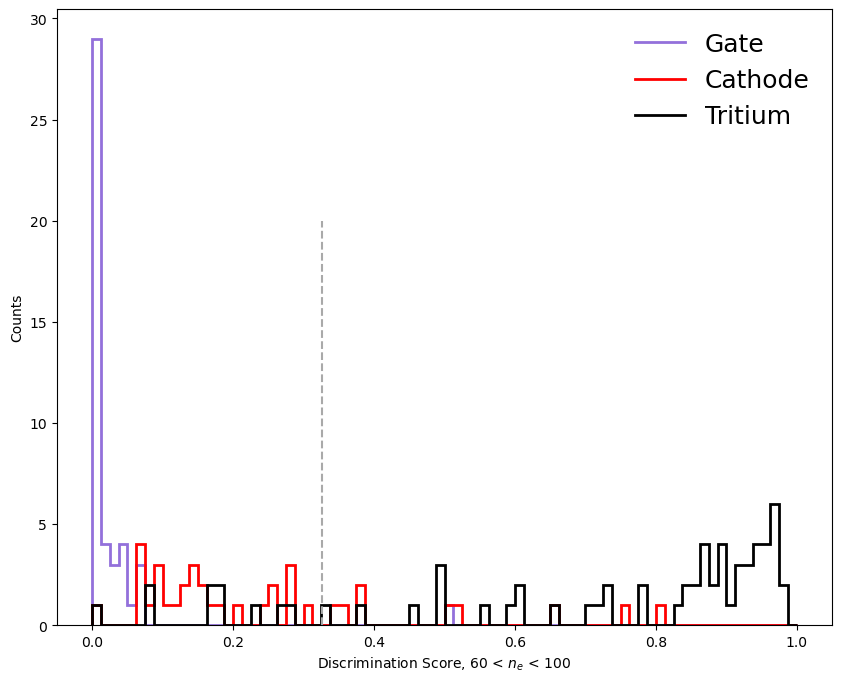

[False  True  True ...  True  True False]


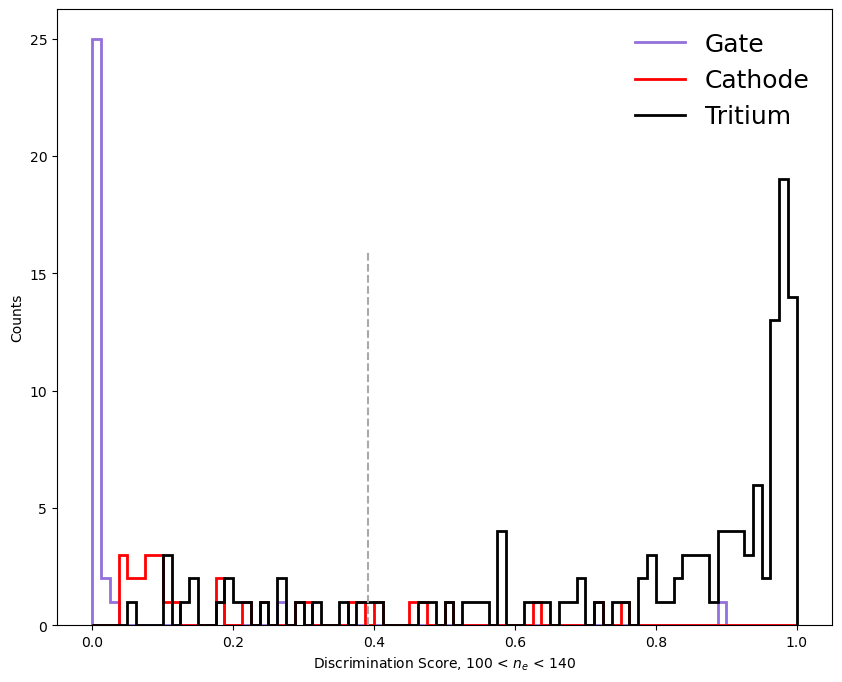

[False  True  True ...  True  True False]


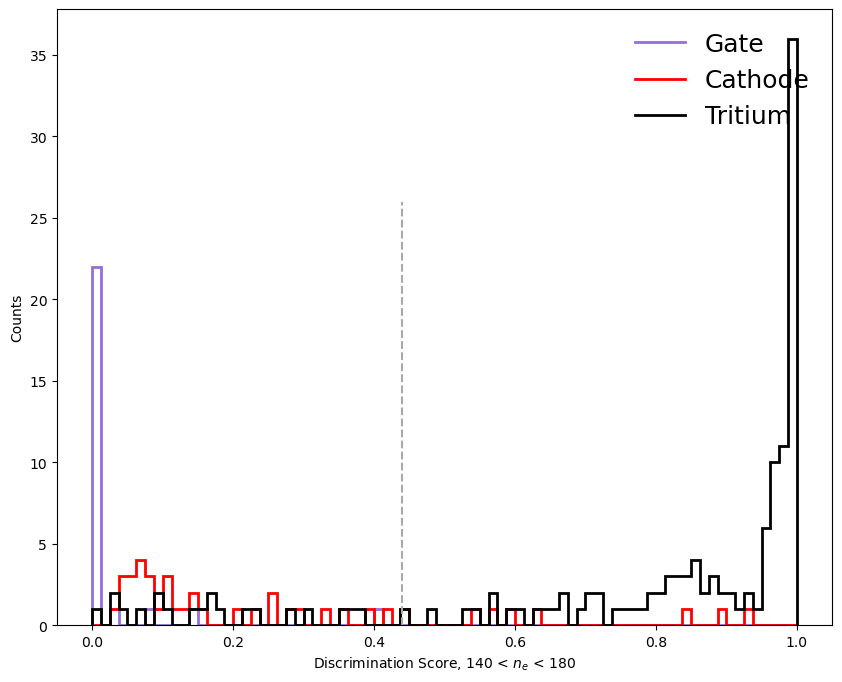

[False  True  True ...  True  True False]


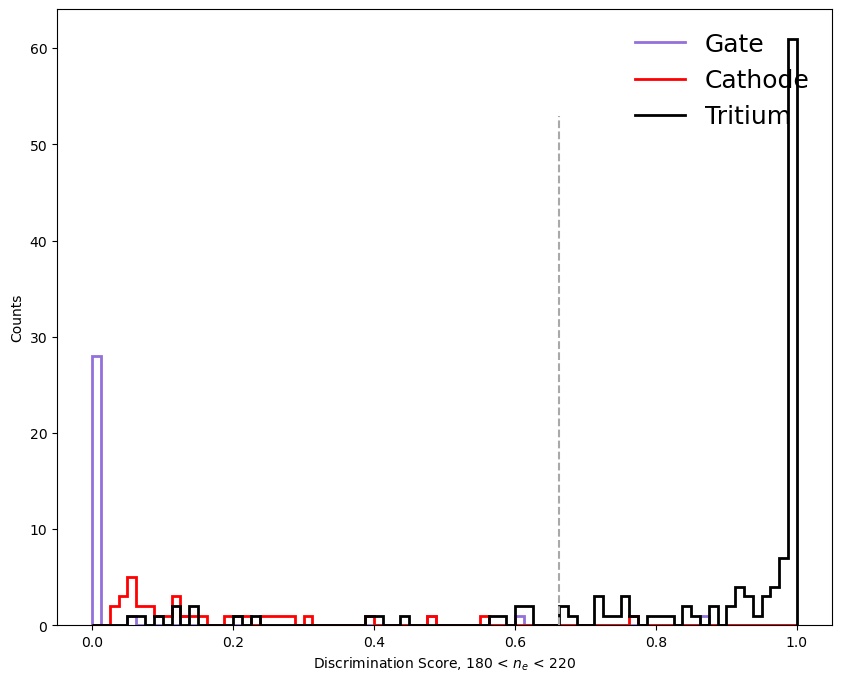

[False  True  True ...  True  True False]


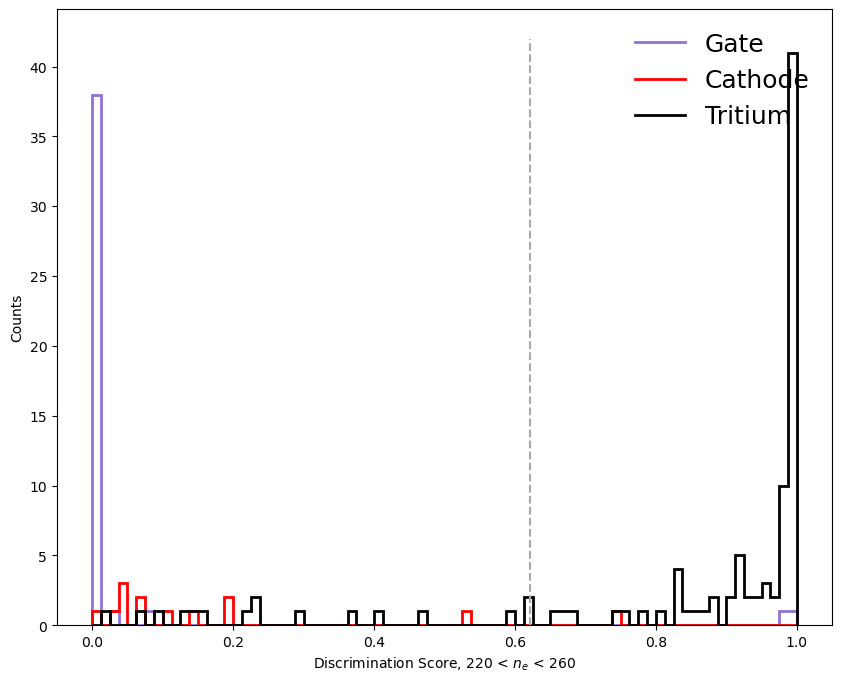

[False  True  True ...  True  True False]


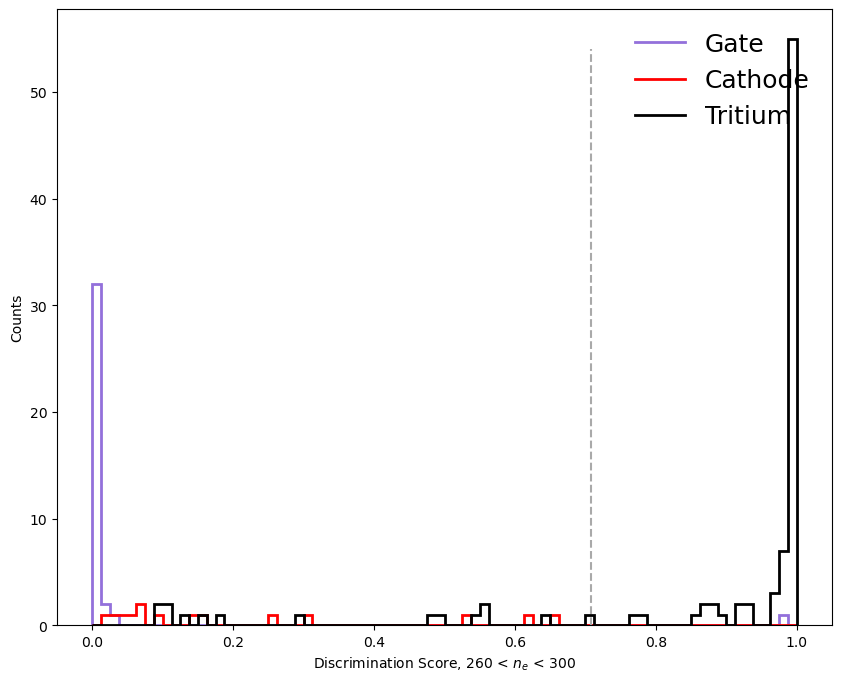

[False  True  True ...  True  True False]


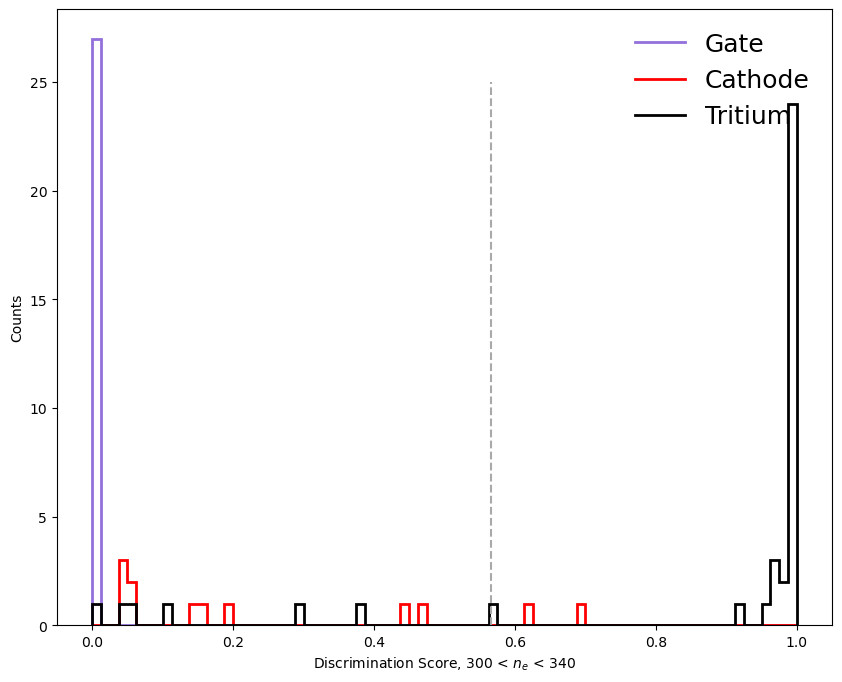

[False  True  True ...  True  True False]


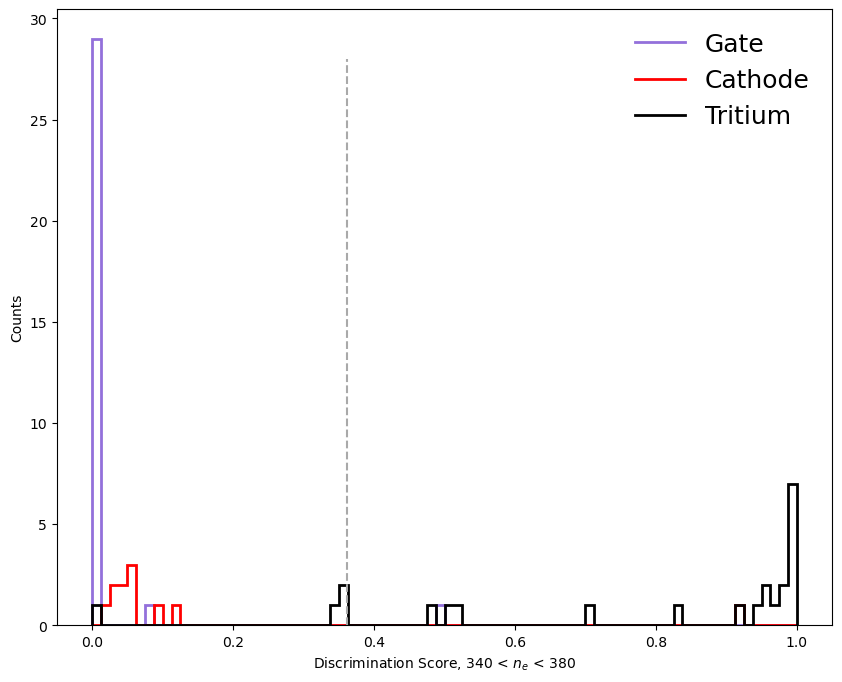

In [411]:
y_predicted_trit = np.expand_dims(y_predicted[:,2], axis=-1)
print(y_predicted_trit.shape)

y_predicted_trit = y_predicted[:,2]
y_test_flat = y_test.flatten()
print(y_test_flat.shape)

tops = [20,16,26,53,42,54,25,28]
y_score_axis =  hist.axis.Regular(80, 0, 1,name="disc_score", label="Signal Probability",flow=False)
cutoffs = []
disc_cuts = []
trit_effs = [[],[]]
cath_effs = [[],[]]
gate_effs = [[],[]]
for i in range(8):

    trit_score_hist = Hist(y_score_axis)
    trit_cut = y_test_flat == 2#'tritium'
    print(trit_cut)
    trit_score_hist.fill(y_predicted_trit[np.where(trit_cut&bin_cuts[i])])

    gate_score_hist = Hist(y_score_axis)
    gate_cut = y_test_flat == 1#'gate'
    gate_score_hist.fill(y_predicted_trit[np.where(gate_cut&bin_cuts[i])])

    cath_score_hist = Hist(y_score_axis)
    cath_cut = y_test_flat == 0#'cathode'
    cath_score_hist.fill(y_predicted_trit[np.where(cath_cut&bin_cuts[i])])

    fig, ax = plt.subplots(figsize=(10, 8))
    gate_score_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
    cath_score_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
    trit_score_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
    
    loc = int(np.round(len(y_predicted_trit[np.where(trit_cut&bin_cuts[i])])*0.15)) 
    cutoff = np.sort(y_predicted_trit[np.where(trit_cut&bin_cuts[i])])[loc]
    cutoffs.append(cutoff)
    disc_cut = y_predicted_trit > cutoff
    disc_cuts.append(disc_cut)
    
    trit_eff = len(E_test[np.where(bin_cuts[i]&trit_cut&disc_cut)])/len(E_test[np.where(bin_cuts[i]&trit_cut)])
    trit_err = np.sqrt(len(E_test[np.where(bin_cuts[i]&trit_cut&disc_cut)]))/len(E_test[np.where(bin_cuts[i]&trit_cut)])
    trit_effs[0].append(trit_eff)
    trit_effs[1].append(trit_err)

    gate_eff = 1 - len(E_test[np.where(bin_cuts[i]&gate_cut&disc_cut)])/len(E_test[np.where(bin_cuts[i]&gate_cut)])
    gate_err = np.sqrt(len(E_test[np.where(bin_cuts[i]&gate_cut&disc_cut)]))/len(E_test[np.where(bin_cuts[i]&gate_cut)])
    gate_effs[0].append(gate_eff)
    gate_effs[1].append(gate_err)
    
    cath_eff = 1 - len(E_test[np.where(bin_cuts[i]&cath_cut&disc_cut)])/len(E_test[np.where(bin_cuts[i]&cath_cut)])
    cath_err = np.sqrt(len(E_test[np.where(bin_cuts[i]&cath_cut&disc_cut)]))/len(E_test[np.where(bin_cuts[i]&cath_cut)])
    cath_effs[0].append(cath_eff)
    cath_effs[1].append(cath_err)
    
    ax.set(xlabel='Discrimination Score, %s'%(bin_labels[i+1]),ylabel='Counts')
    ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)
    ax.plot([cutoff,cutoff], [0,tops[i]], linestyle='--', color='darkgray')
    
    #plt.savefig('%s'%(i))
    plt.show()

Gate Effs - 0.9760712321952241 +/- 0.009129825623600984
Cath Effs - 0.8705488591248993 +/- 0.027399405454673068


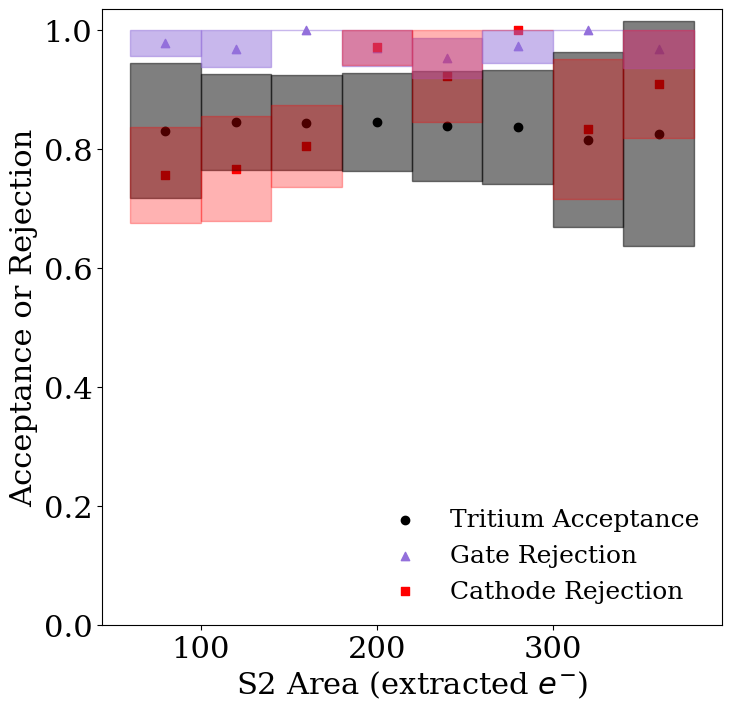

In [439]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'serif','weight' : 'normal','size'   : 22}
plt.rc('font', **font)

bin_centres = [80, 120, 160, 200, 240, 280, 320, 360]
fig, ax = plt.subplots(figsize = (8,8))

ax.scatter(bin_centres, trit_effs[0], label = 'Tritium Acceptance', color = 'black')
ax.scatter(bin_centres, gate_effs[0], label = 'Gate Rejection', color = 'mediumpurple', marker = '^')
ax.scatter(bin_centres, cath_effs[0], label = 'Cathode Rejection', color = 'red', marker = 's')

for i in range(8):
    trit_rec = Rectangle((bin_centres[i]-20, trit_effs[0][i]-trit_effs[1][i]), 40, 2*trit_effs[1][i], color = 'black', alpha = 0.5)
    gate_rec = Rectangle((bin_centres[i]-20, gate_effs[0][i]-gate_effs[1][i]), 40, 2*gate_effs[1][i], color = 'mediumpurple', alpha = 0.5)
    cath_rec = Rectangle((bin_centres[i]-20, cath_effs[0][i]-cath_effs[1][i]), 40, 2*cath_effs[1][i], color = 'red', alpha = 0.3)
    ax.add_patch(trit_rec)
    ax.add_patch(gate_rec)
    ax.add_patch(cath_rec)
ax.set_ylim(0)
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 18)
ax.set_xlabel(r'S2 Area (extracted $e^{-}$)')
ax.set_ylabel('Acceptance or Rejection')
plt.savefig('discperformance_formatting.pdf', format='pdf')

gate_errors = np.array(gate_effs[1])
cath_errors = np.array(cath_effs[1])

print('Gate Effs - ' + str(np.mean(gate_effs[0])) + ' +/- ' + str(np.sqrt(np.sum(gate_errors**2)) / len(gate_errors)))
print('Cath Effs - ' + str(np.mean(cath_effs[0])) + ' +/- ' + str(np.sqrt(np.sum(cath_errors**2)) / len(cath_errors)))

## best two layer activation maps 

### layer 1

In [413]:
# Assume `model` is your original CNN model and 'conv_layer_name' is the name of the layer you want to inspect
layer_outputs = [layer.output for layer in two_layer_CNN_model.layers if layer.name == 'conv1d_36']
activation_model = Model(inputs=two_layer_CNN_model.input, outputs=layer_outputs)

(1, 1528, 1)
(1528,)


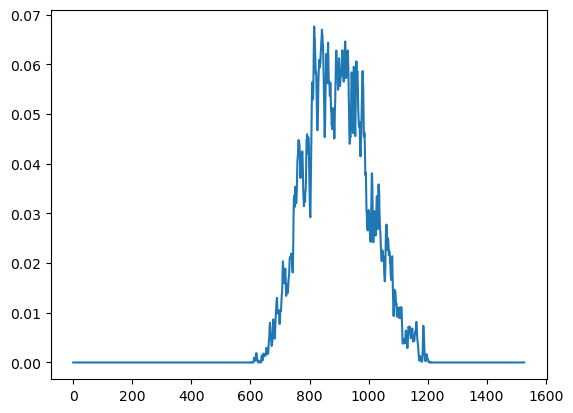

1/1 [==============================] - 0s 63ms/step


In [414]:
print(X_test[1000,:].reshape(1, input_length, 1).shape)
print(X_test[1000].shape)

plt.figure()
plt.plot(X_test[1000,:])
plt.show()

activations = activation_model.predict(X_test[1000].reshape(1, input_length, 1))

# print(chonky_padded_waveforms[chonky_padded_waveforms.length == len(X_test[1000])])

(629, 6)
6


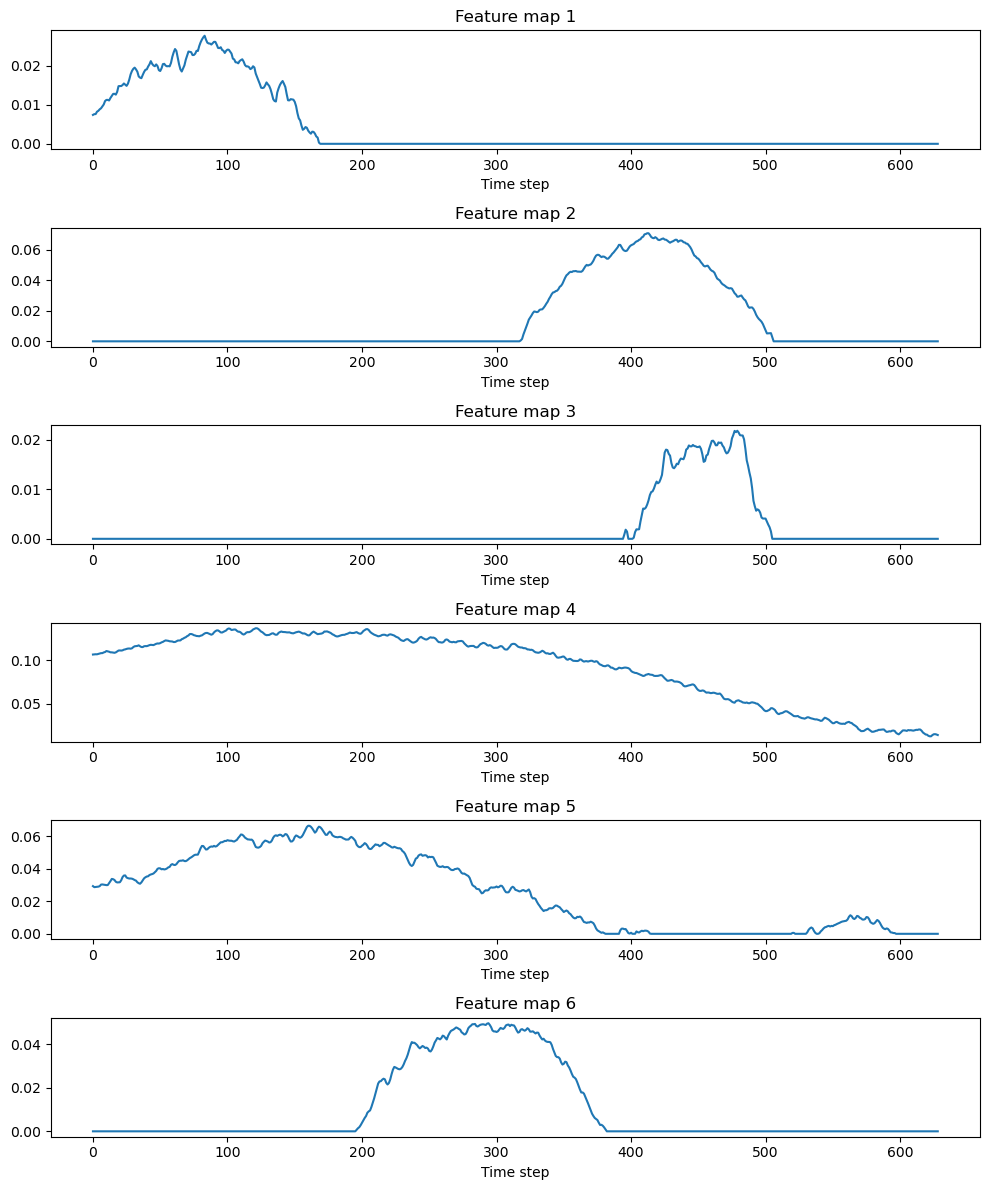

In [415]:
# Assuming you're visualizing the first layer's activations for simplicity
first_layer_activations = activations[0]
print(first_layer_activations.shape)

# Choose how many features maps you'd like to display
n_features = first_layer_activations.shape[-1]
print(n_features)

# Prepare the plot
fig, axes = plt.subplots(n_features, 1, figsize=(10, n_features * 2))

if n_features == 1:
    axes = [axes]  # Ensure axes is iterable for a single feature map

for i, ax in enumerate(axes):
    # Plot each activation map
    feature_map = first_layer_activations[:, i]
    ax.plot(feature_map)
    ax.set_title(f'Feature map {i+1}')
    ax.set_xlabel('Time step')
    plt.tight_layout()

plt.show()

### layer 2

In [416]:
# Assume `model` is your original CNN model and 'conv_layer_name' is the name of the layer you want to inspect
layer_outputs = [layer.output for layer in two_layer_CNN_model.layers if layer.name == 'conv1d_37']
activation_model = Model(inputs=two_layer_CNN_model.input, outputs=layer_outputs)

In [417]:
activations = activation_model.predict(X_test[1000].reshape(1, input_length, 1))

1/1 [==============================] - 0s 45ms/step


(591, 38)
38


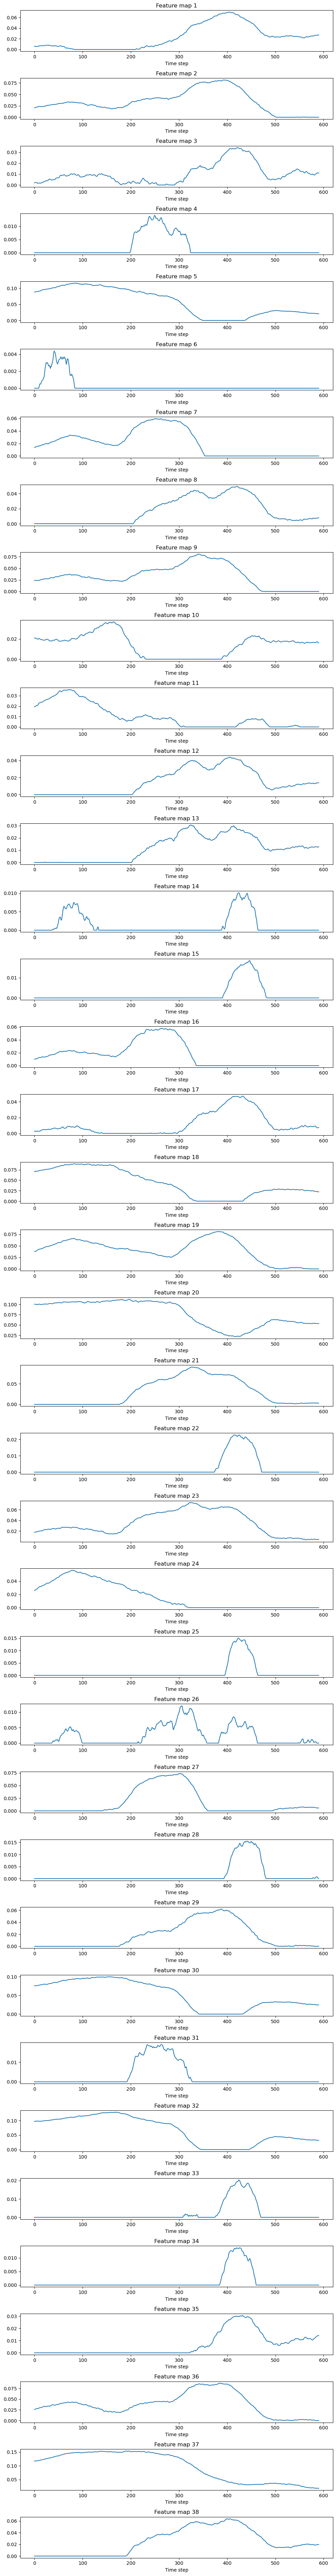

In [418]:
# Assuming you're visualizing the first layer's activations for simplicity
first_layer_activations = activations[0]
print(first_layer_activations.shape)

# Choose how many features maps you'd like to display
n_features = first_layer_activations.shape[-1]
print(n_features)

# Prepare the plot
fig, axes = plt.subplots(n_features, 1, figsize=(10, n_features * 2))

if n_features == 1:
    axes = [axes]  # Ensure axes is iterable for a single feature map

for i, ax in enumerate(axes):
    # Plot each activation map
    feature_map = first_layer_activations[:, i]
    ax.plot(feature_map)
    ax.set_title(f'Feature map {i+1}')
    ax.set_xlabel('Time step')
    plt.tight_layout()

plt.show()

## setting a decision threshold

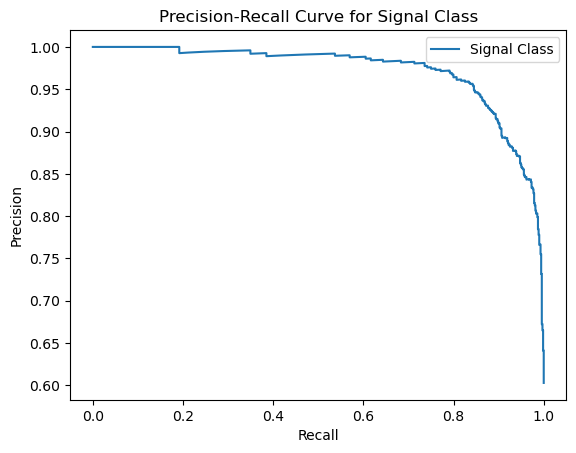

In [419]:
# relabelling as a signal vs background problem

signal_probs = y_predicted[:, 2]

# Convert `y_test` to binary: 1 for signal class, 0 for background classes
y_test_binary = (y_test == 2).astype(int)

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test_binary, signal_probs)

# Plotting the Precision-Recall Curve
plt.plot(recall, precision, label='Signal Class')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Signal Class')
plt.legend()
plt.show()

In [420]:
# Assuming you have precision, recall, thresholds from precision_recall_curve
f1_scores = 2 * (precision * recall) / (precision + recall)
max_f1_index = np.argmax(f1_scores)  # Index of maximum F1 score
optimal_threshold = thresholds[max_f1_index]
print(len(f1_scores))
print(max_f1_index)
print(f1_scores[max_f1_index])

print(f"Optimal Threshold for Max F1: {optimal_threshold}")

# Assuming you have precision, recall, and thresholds from precision_recall_curve
beta = 2  # The beta parameter weights recall more than precision.
f2_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
max_f2_index = np.argmax(f2_scores)  # Index of maximum F2 score
optimal_threshold_for_f2 = thresholds[max_f2_index]
print(f2_scores[max_f2_index])

print(f"Optimal Threshold for Max F2: {optimal_threshold_for_f2}")

1169
402
0.9074829931972789
Optimal Threshold for Max F1: 0.14451949298381805
0.9442766950315674
Optimal Threshold for Max F2: 0.08251653611660004
